# Astronomy 443 - Lab 1

## Purpose
The objectives of this lab are to learn how to use the equipment needed to conduct observations during the semester. This equipment includes the STL-1001E, the ST402ME, DADOS spectrographs, and the Mt. Stony Brook 14-inch telescope. Sets of calibration data for imaging and spectroscopic observations were taken, and strategies on analyzing said data were developed.

## 4.1  Bias Frames
A bias frame is an exopsure of 0 seconds, with the camera shutter closed, at the temperature of observation. They are used to determine the bias level of every pixel and weed out faulty ones (e.g. hot pixels). The below image is a bias frame at the temperature of observation, -5 Celsius.

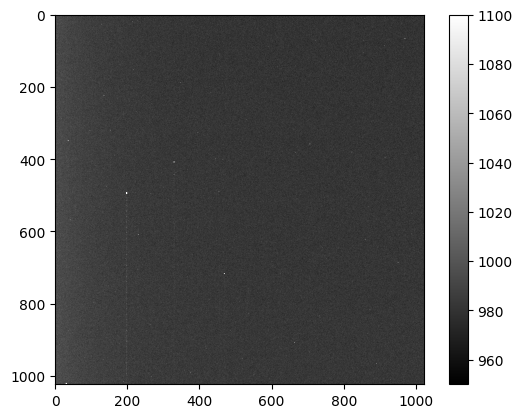

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

#open FITs file
list = fits.open("../Lab_1/images/lab1_bias.00000001.BIAS.FIT")

#get date from FITs file
image_data = list[0].data

plt.imshow(image_data,cmap='gray', vmin=950, vmax=1100)
plt.colorbar()

Astropy's unique FITs file handling functions make it quick and easy to plot the count levels of the intensities of pixels. 

Text(0.5, 1.0, 'Raw Data')

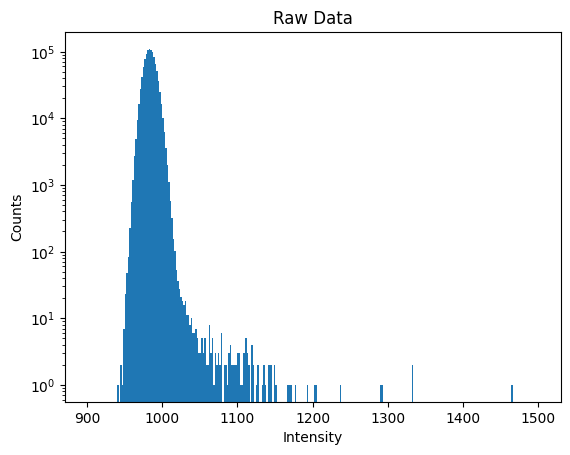

In [2]:
flat_data = image_data.flatten()
histogram = plt.hist(flat_data, range=(900,1500),log=True, bins=300)
plt.ylabel('Counts')
plt.xlabel('Intensity')
plt.title('Raw Data')

It can be seen in the graph above that there are some pixels with a large dark current, causing them to become saturated. To filter the data, an intensity threshold is applied to the original data. Essentially, any pixels with a count greater than the threshold (1050 in this case) will be discarded from all of the data.

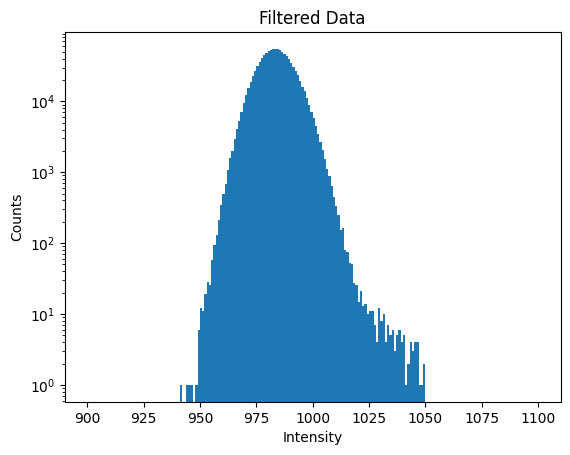

In [3]:
threshold = 1050

# Create a boolean mask indicating elements below the threshold
mask = flat_data < threshold

# Use the boolean mask to filter the data
filtered_data = flat_data[mask]

plt.hist(filtered_data, range=(900,1100),log=True, bins=200)

plt.title('Filtered Data')
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.show()

In [4]:
num_cut = len(flat_data) - len(filtered_data)
frac_cut = (len(flat_data)-len(filtered_data))/len(flat_data) * 100

print(f'number cut from original data: {num_cut}')
print(f'fraction cut from original data: {frac_cut}')

number cut from original data: 133
fraction cut from original data: 0.012683868408203125


The graph of Filtered Data provides a more even distribution of counts, as there are no more erronious outliers. By subtracting the number of counts of the filtered data from the number of counts of the raw data, it is determined that there were 133 hot pixels (about 0.0127% of pixels).

Using Numpy's mean and standard deviation functions, the following were calculated:

In [5]:
print('Mean:', np.mean(filtered_data))
print('Stdev:', np.std(filtered_data))

Mean: 983.3167630476812
Stdev: 7.8315264971103025


Using the calculated mean and standard deviation values, Astropy was once again utalized to plot an overlaying Gaussian. Astropy contains a variety of models and fitting algorithms, of which Gaussian1D and LevMarLSQFitter are used here to produce the desired fit.

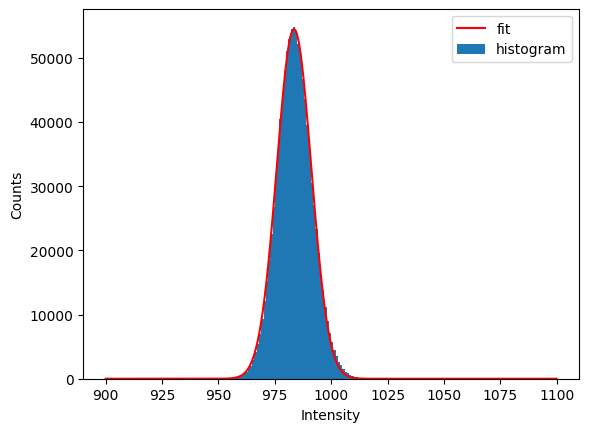

In [6]:
from astropy.modeling import models, fitting

def plot_gaussian(data, r, mu, sigma, num_bins):

    #Get counts and bins
    bin_heights, bin_borders = np.histogram(data, range = r,bins = num_bins)
    bin_widths = np.diff(bin_borders)
    bin_centers = bin_borders[:-1] + bin_widths / 2

    #initialize Gaussian model
    gaussian = models.Gaussian1D(mean=mu,stddev=sigma)
    #Select fitting algorithm to be used
    fitter = fitting.LevMarLSQFitter()
    #Make best fit function
    best_fit = fitter(gaussian, bin_centers, bin_heights)

    #Determine useful x-values for Gaussian fit
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    #Make plots
    plt.figure()
    plt.bar(bin_centers, bin_heights, width=bin_widths, label='histogram',log=False)
    plt.plot(x_interval_for_fit, best_fit(x_interval_for_fit), label='fit', c='red')
    plt.xlabel('Intensity')
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

plot_gaussian(filtered_data,mu = 983.32,sigma = 7.83, r = (900,1100),num_bins=200)

The gain, number of electrons, and number of counts are related by:
$$gain = \frac{N_{electrons}}{N_{counts}}  $$

Using the spec sheet for the STL1001E, the actual gain is 2 and the number of electrons is 14.8e RMS. With a read noise equal to the standard deviation of counts, 7.83, the number of electrons was found to be:
$$2 \times 7.83 = 15.66e^-$$

While this is approximately one electron higher than the spec sheet, it is also relatively accurate.

## 4.2 Dark Frames
Dark frames are images taken with the shutter closed, but with the same exposure time as the science images. They are useful in identifying hot pixels and the dark current of each pixel. 

### 4.2.1 Median Combine and Hot Pixels
To make our master dark frame, we first must combine our 10 dark frames to identify hot pixels. The codes below store the dark frame files in a list, named **list**, and iterate through each file to find the median values between them. These median values are then stored in **median_values** for plotting of the combine.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))
# ^This import is to have a larger display on the output, I'm not sure how to
# do that in Notebook

# find and open the Dark FITS files that were exposed for 30 secs and store them all in one list
file_prefix = "lab1_3_2_3.0000000"
file_end = ".DARK.FIT"
pixel_data = [None]*10

for i in range(0, 10, 1):
    filename = file_prefix + str(i) + file_end
    list = fits.open('../Lab_1/images/'+filename)
    image_data = list[0].data
    pixel_data[i] = image_data


/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_17451/4127876634.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [8]:
# open a 2d list to store median values
median_values = np.zeros((1024, 1024))

# run through and calculate the median value for each pixel
for i in range(0, 1024):
    for j in range(0, 1024):
        values = [pixel_data[x][i][j] for x in range(0,10)]
        median_values[i][j] = np.median(values)
        

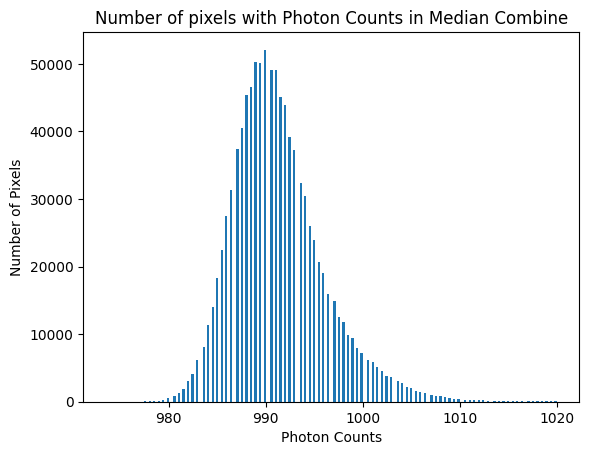

Text(0.5, 1.0, 'Number of Pixels with Photon Counts in Median Combine')

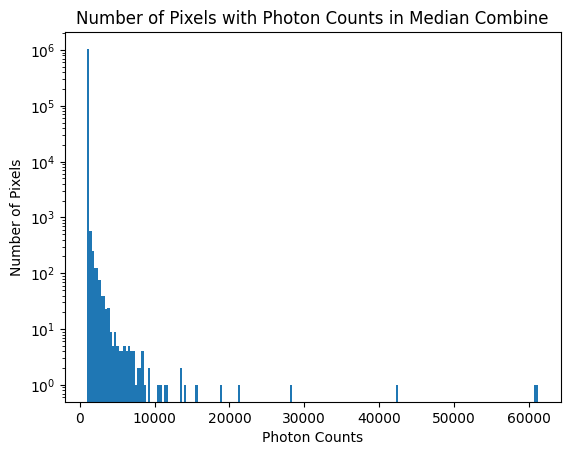

In [9]:
# flatten the data so we can calculate counts of certain values
flat_data = median_values.flatten()
med_min = np.min(flat_data)
# A lot of the data past this point is not a part of the normal distrubution
med_max = 1020
histogram = plt.hist(flat_data, range = (med_min, med_max), bins=200)
plt.xlabel('Photon Counts')
plt.ylabel('Number of Pixels')
plt.title("Number of pixels with Photon Counts in Median Combine")
plt.show()
#I am making a plot so we can see how high some of these pixels go with their counts
histogram2 = plt.hist(flat_data, range = (np.min(flat_data), np.max(flat_data)), bins = 200)
plt.xlabel('Photon Counts')
plt.ylabel('Number of Pixels')
plt.yscale("log")
plt.title("Number of Pixels with Photon Counts in Median Combine")

By looking at the logarithmic histogram of photon counts of the combine, the warm and hot pixels can clearly be identified. Based on these data, we have defined warm pixels as 10,000 < counts < 20,000, and hot pixels as counts >= 20,000. The below figures display two images of the combine. The first is with warm and hot pixels marked, and the second is without these extremeties noted.

In [10]:
# Creating a list to store the indices of the hot and warm pixels so we can see them on the median combine
# I set the threshold of hot pixels to be ones with >= 20,000 counts, and warm pixels from 10,000-20,0000 counts
# Everything below that just seemed like it wasn't that warm/hot

hot_pixels = []
warm_pixels = []
for i in range(0, 1024):
    for j in range(0, 1024):
        if median_values[i][j] >= 20000:
            hot_pixels.append([i, j])
        elif 10000 < median_values[i][j] < 20000:
            warm_pixels.append([i, j])

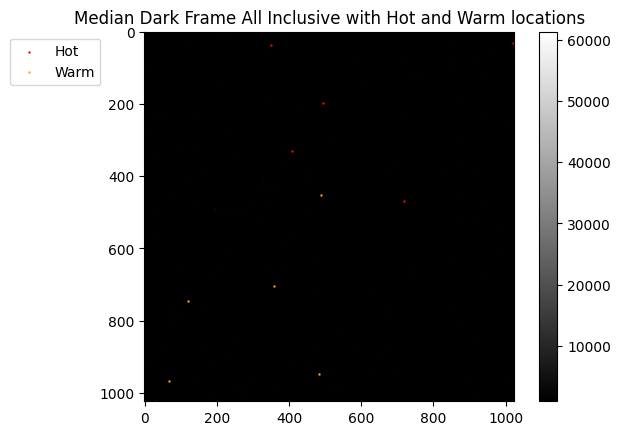

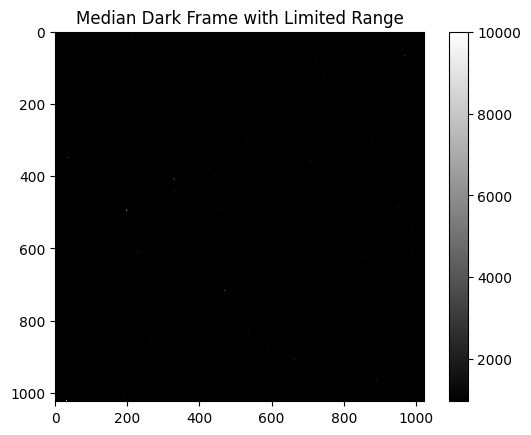

In [11]:
# I set the minimum rounded down to the tens place and set the maximum to the highest count to see how our
# hot and warm pixels appear

minimum = 970
maximum = np.max(flat_data)
plt.imshow(median_values, cmap='gray', vmin=minimum, vmax=maximum)
plt.title("Median Dark Frame All Inclusive with Hot and Warm locations")
plt.colorbar()

# Setting the indices in the lists to actual locations so that we can plot them as points on the image
x_indices = [hot_pixels[x][0] for x in range(0, len(hot_pixels))]
y_indices = [hot_pixels[x][1] for x in range(0, len(hot_pixels))]
xw = [warm_pixels[x][0] for x in range(0, len(hot_pixels))]
yw = [warm_pixels[x][1] for x in range(0, len(hot_pixels))]
plt.scatter(x_indices, y_indices, color='red', s=0.5, label = 'Hot')
plt.scatter(xw, yw, color='orange', s=0.5, label = 'Warm')
plt.legend(bbox_to_anchor=(-0.1, 1))
plt.show()

#Creating the image disregarding the warm and hot pixels
plt.imshow(median_values, cmap='gray', vmin=minimum, vmax=10000)
plt.title("Median Dark Frame with Limited Range")
plt.colorbar()

Our next step is to iterate through each dark frame and determine 3 conditions:

1. The warm/hot pixel is present in both the median image and the single image
2. The warm/hot pixel is present in only the median image
3. The warm/hot pixel is present in only the single image

If a pixel is warm or hot in the median image and also in all of the individual images, it is classified as "double warm/hot" in the code. Otherwise, if a pixel is warm or hot in the median image but does not consistently appear in every image, it is suspected to have been affected by an anomaly.

As can be seen by analysis of the code, there is no instance in which a pixel is warm or hot but does not appear in the combine. This leads us to conclude that no cosmic rays or other anomalies affected our results. These final warm and hot pixels are located as follows:

1. Hot: [350, 36] , [409, 329] , [495, 198] , [718, 468] , [1022, 31]
2. Warm: [67, 968] , [119, 746] , [359, 705] , [484, 949] , [490, 453] , [610, 230] , [874, 589] , [909, 662] , [967, 889]

In [12]:
# Here we're running throught the pixels of each image to determine whether they are warm/hot in:
# 1. In the median combine and the image, 2. Just in the image 3. Just in the median combine

both_hot = [None] * 10
both_warm = [None] * 10
median_warm = [None]*10
median_hot = [None]*10
image_warm = [None]*10
image_hot = [None]*10
double_hot_indices = []
double_warm_indices = []

for i in range(0, 10):
    h = 0
    w=0
    mw = 0
    mh = 0
    iw = 0
    ih = 0
    print(f"\n We are now in Dark image # {i+1}")
    for j in range(0, 1024):
        for k in range(0, 1024):
            if pixel_data[i][j][k] >= 20000 and [j, k] in hot_pixels:
                h += 1
                both_hot[i] = h
                if [j, k] not in double_hot_indices:
                    double_hot_indices.append([j, k])
                else:
                    print(f"Another double hot for [{j}, {k}]")
            elif pixel_data[i][j][k] >= 20000 and [j, k] not in hot_pixels:
                ih += 1
                image_hot[i] = (ih)
            elif pixel_data[i][j][k] < 20000 and [j, k] in hot_pixels:
                mh += 1
                median_hot[i] = mh
            elif 10000 < pixel_data[i][j][k] < 20000 and [j, k] in warm_pixels:
                w += 1
                both_warm[i] = w
                if [j, k] not in double_warm_indices:
                    double_warm_indices.append([j, k])
                else:
                    print(f"Another double warm for [{j}, {k}]")
            elif 10000 < pixel_data[i][j][k] < 20000 and [j, k] not in warm_pixels:
                iw += 1
                image_warm[i] = iw
            elif 10000 < pixel_data[i][j][k] < 20000 and [j, k] in warm_pixels:
                mw += 1
                median_only_warm[i] = mw
    print(f"Number of pixels hot in both is {both_hot[i]}")
    print(f"Number of pixels warm in both is {both_warm[i]}")
    print(f"Number of pixels only warm in median and not this image is {median_warm[i]}")
    print(f"Number of pixels only hot in median and not this image is {median_hot[i]}")
    print(f"Number of pixels only hot in this image and not in median is {image_hot[i]}")
    print(f"Number of pixels only warm in this image and not in median is {image_warm[i]}")


 We are now in Dark image # 1
Number of pixels hot in both is 5
Number of pixels warm in both is 9
Number of pixels only warm in median and not this image is None
Number of pixels only hot in median and not this image is None
Number of pixels only hot in this image and not in median is None
Number of pixels only warm in this image and not in median is None

 We are now in Dark image # 2
Another double warm for [67, 968]
Another double warm for [119, 746]
Another double hot for [350, 36]
Another double warm for [359, 705]
Another double hot for [409, 329]
Another double warm for [484, 949]
Another double warm for [490, 453]
Another double hot for [495, 198]
Another double warm for [610, 230]
Another double hot for [718, 468]
Another double warm for [874, 589]
Another double warm for [909, 662]
Another double warm for [967, 889]
Another double hot for [1022, 31]
Number of pixels hot in both is 5
Number of pixels warm in both is 9
Number of pixels only warm in median and not this image i

### 4.2.2 Calculating Dark Current
Dark current occurs in cameras that are not cooled to below -100 Celsius. This phenomenon is the explanation of electrons being released and tunneling into the conduction band of the CCD semiconductor, mimicking a photon signal. 

For this section, we will be looking at Dark Frames that have exposure times ranging from 10 seconds to 2 minutes. Similarly to Section 4.2.1, we will combine these files and analyze a logarithmic histogram to determine where hot/warm pixels occur.   

In [15]:
# find and open the Dark FITS files that were exposed from 10s - 2min in intervals of 10 sec
# and storing them in one file
series_data = [None] * 13 

list = fits.open("../Lab_1/images/lab1_bias.00000001.BIAS.FIT")
series_data[0] = list[0].data

file_pre = "lab1_dark.000000"
file_suf = ".DARK.FIT"

for i in range(0, 12):
    if i < 8:
        file_pref = file_pre + '0'
        file_name = file_pref + str(i + 2) + file_suf
        list = fits.open("../Lab_1/images/" + file_name)
        image_data = list[0].data
        series_data[i+1] = image_data
    else:
        file_name = file_pre + str(i + 2) + file_suf
        list = fits.open("../Lab_1/images/" + file_name)
        image_data = list[0].data
        series_data[i+1] = image_data

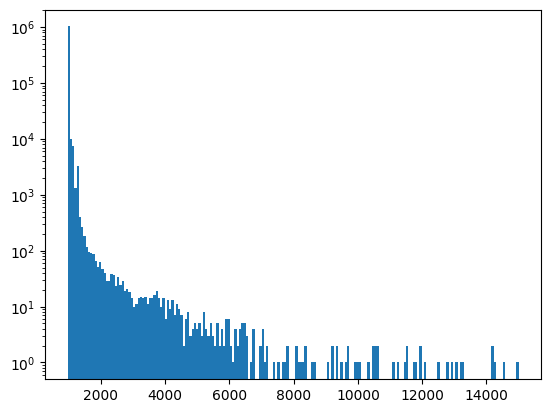

In [16]:
flat_data = series_data[6].flatten()
min = np.min(flat_data)
max = 15000
histogram = plt.hist(flat_data, range = (min, max), bins = 200)
plt.yscale("log")
plt.show()

Based on the histogram, we can determine where to cut off the warm and hot pixels. The statistical and systemic uncertainties are then calculated and compared:

In [17]:
# Creating a list of minimums and maximums that set the range to get a good representation of our normal
# distribution, essentially ignoring the outlying warm and hot pixels

from scipy import stats

maxs = [1250, 4000, 6500, 10000, 12000, 10000, 10000, 10000, 10000, 10000, 11000, 12200, 13000]
mean_counts = []
st_devs = []
stat_uncs = []

# Running through the images and flattening the data, sampling our data to including the counts within
# the range set to represent our data. We calculate the mean, standard deviation, and uncertainty of the mean
# of this sample, and store these values

for i in range(0,13):
    flat_data = series_data[i].flatten()

    series_min = np.min(flat_data)
    series_max = maxs[i]
    data_set = []
    for j in range(0, len(flat_data)):
        if series_min < flat_data[j] < series_max:
            data_set.append(flat_data[j])

    mean = np.mean(data_set)
    mean_counts.append(mean)
    st_dev = stats.tstd(data_set)
    st_devs.append(st_dev)
    stat_unc = mean / np.sqrt(len(data_set))
    stat_uncs.append(stat_unc)

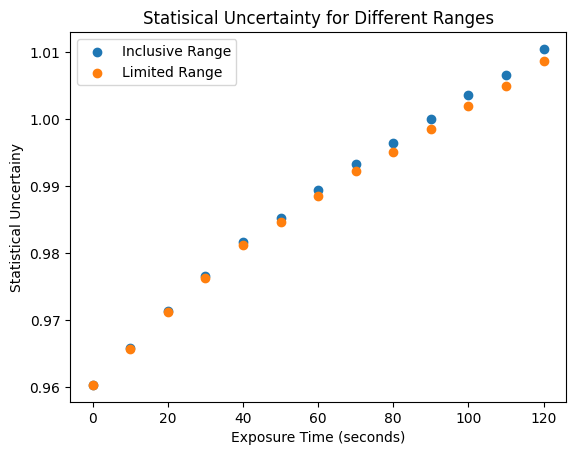

In [18]:
# Here we are calculating the uncertainty once again but this time including more and then all of
# the data points collected, so that we can see the systemic uncertainty
whole_st_devs = []
whole_stat_uncs = []

for i in range(0,13):
    flat_data = series_data[i].flatten()

    series_min = np.min(flat_data)
    series_max = np.max(flat_data)
    data_set = []
    mean = np.mean(flat_data)
    st_dev = stats.tstd(flat_data)
    whole_st_devs.append(st_dev)
    stat_unc = mean / np.sqrt(len(flat_data))
    whole_stat_uncs.append(stat_unc)

exposure_times = [10 * x for x in range(0, 13)]

plt.scatter(exposure_times, whole_stat_uncs, label="Inclusive Range")
plt.scatter(exposure_times, stat_uncs, label="Limited Range")
plt.title("Statisical Uncertainty for Different Ranges")
plt.xlabel("Exposure Time (seconds)")
plt.ylabel("Statistical Uncertainy")
plt.legend()

Becaused dark current is given in units of electrons/pixel/second, we need to plot the mean counts vs. exposure time of our dark frames. The dark current is then just the slope of our line of best fit. We determine this slope to be 0.7996 +/- 0.0258 e/p/s.

The dark current rate is 0.7996 +/- 0.0258 e/p/s
The offsest is 986.5088 +/- 0.9112


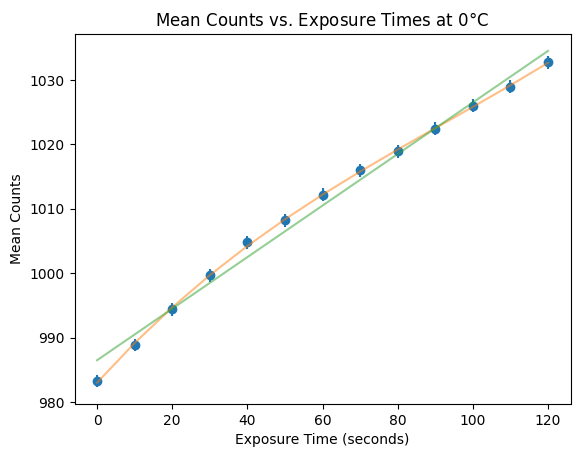

In [19]:
# importing curve_fit to fit a line to our data

from scipy.optimize import curve_fit

# creating a list of the exposure time values in seconds and plotting our mean counts to their
# corresponding exposure times


plt.scatter(exposure_times, mean_counts)
plt.errorbar(exposure_times, mean_counts, yerr=stat_uncs, linestyle='')
plt.xlabel("Exposure Time (seconds)")
plt.ylabel("Mean Counts")
plt.title("Mean Counts vs. Exposure Times at 0$\\degree$C")

# defining the function of a line so that we can model our data
def linear(exposure, dark_current_rate, offset):
    """
    fitting a line to our data of mean counts vs. exposure time
    
    param exposure: The amount of time the frame was exposed for
    param dark_current_rate: the dark current in electrons per pixel per second
    param offset: The number of electrons the measurements are offset by
    
    """
    return dark_current_rate * exposure + offset

def cubic(exposure, a, b, c, d):
    """ trying a cubic function just to see how well it fits our mean counts, possibly
    seeing that there's a different relationship between our values
    
    Not really sure what the parameters a, b, c, and d would represent
    
    param exposure: The amount of time the frame was exposed for
    
    """
    return a*(exposure ** 3) + b*(exposure ** 2) + c*exposure + d

# extracting our dark current rate and the offset from the fit, along with the covariance of thes vlaues
parameters, covariance = curve_fit(linear, exposure_times, mean_counts)
dark_current_rate, offset = parameters
uncertainty_in_dcr = np.sqrt(covariance[0][0])
uncertainty_in_offset = np.sqrt(covariance[1][1])

p, c = curve_fit(cubic, exposure_times, mean_counts)
a, b, c, d = p
cubics = [cubic(exposure, a, b, c, d) for exposure in exposure_times]
plt.plot(exposure_times, cubics, alpha = 0.5)

gain = 2.0

print(f"The dark current rate is {dark_current_rate * gain:.4f} +/- {uncertainty_in_dcr * gain:.4f} e/p/s")
print(f"The offsest is {offset:.4f} +/- {uncertainty_in_offset:.4f}")

model_mean_counts = [linear(exposure, dark_current_rate, offset) for exposure in exposure_times]
plt.plot(exposure_times, model_mean_counts, alpha = 0.5)

Our farthest mean count is within 0.4005 sigmas


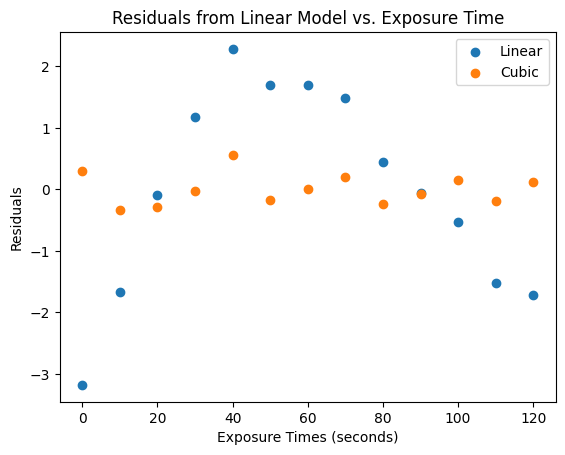

In [20]:
# Calculating the residuals by finding the difference between actual value and model value
residuals = []
residuals_cubic = []

for i in range(0, len(mean_counts)):
    distance = mean_counts[i] - linear(exposure_times[i], dark_current_rate, offset)
    distance_cubic = mean_counts[i] - cubic(exposure_times[i], a, b , c, d)
    residuals.append(distance)
    residuals_cubic.append(distance_cubic)

plt.scatter(exposure_times, residuals, label="Linear")
plt.scatter(exposure_times, residuals_cubic, label="Cubic")
print(f"Our farthest mean count is within {np.abs(residuals[0]) / st_devs[0]:.4f} sigmas")
plt.title("Residuals from Linear Model vs. Exposure Time")
plt.ylabel("Residuals")
plt.xlabel("Exposure Times (seconds)")
plt.legend()

The dark current at -15 degrees C is 1.8304 +/- 0.7025 e/p/s


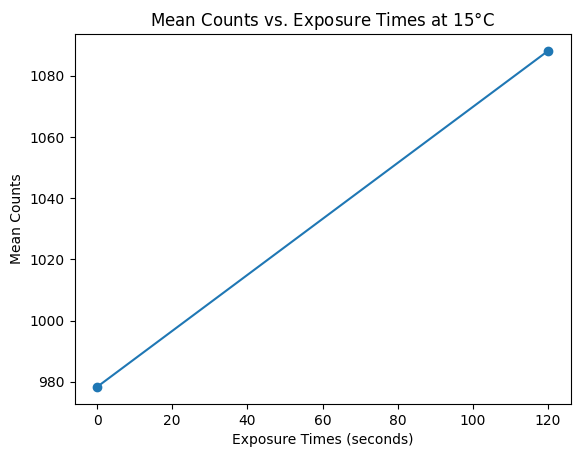

In [21]:
# Here we are estimating the dark current of our Bias Frame and our Dark frame at -15 degrees C

bias = fits.open("../Lab_1/images/lab1_3_2_4.00000010.BIAS.FIT")
dark = fits.open("../Lab_1/images/lab1_3_2_4.00000011.DARK.FIT")

bias_frame = bias[0].data
dark_frame = dark[0].data

flat_dark = dark_frame.flatten()
flat_bias = bias_frame.flatten()

dark_data=[]
bias_data=[]

for i in range(0, len(flat_dark)):
    if flat_dark[i] < 10000:
        dark_data.append(flat_dark[i])
    if flat_bias[i] < 10000:
        bias_data.append(flat_bias[i])
        

bias_mean = np.mean(bias_data)
dark_mean = np.mean(dark_data)
std_dev_15 = [stats.tstd(bias_data), stats.tstd(dark_data)]

means = [bias_mean, dark_mean]
times = [0, 120]
offset_15 = bias_mean
dark_current_rate_15 = (dark_mean - bias_mean) / (120. - 0)
uncertainty_dcr_15 = (np.sqrt(std_dev_15[1]**2 + std_dev_15[0]**2)) / 120.

plt.plot(times, [dark_current_rate_15 * x + offset_15 for x in times])
plt.title("Mean Counts vs. Exposure Times at 15$\\degree$C")
plt.xlabel("Exposure Times (seconds)")
plt.ylabel("Mean Counts")
plt.scatter(times, means)

print(f"The dark current at -15 degrees C is {dark_current_rate_15 * gain:.4f} +/- {uncertainty_dcr_15:.4f} e/p/s")

## 4.3 Flat Fields
Flat fields refer to images taken to correct for non-uniformity in detector sensitivity. These anomolies arise mainly in variations in the sensitivity of the detector and dust particles on the optical elements. A master flat field is then applied to all of the science images taken during an observation in order to reduce the effects of the previously stated anomolies.

To produce the master flat field, we must:
1) Take the median of the total number of flat fields (10 in our case)
2) Normalize the median combine

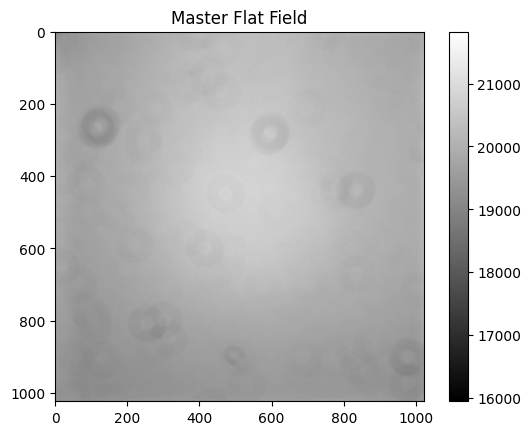

In [25]:
# find and open the Flat Field FITS files and store them all in one list
file_prefix = "lab1_3_3_series.0000000"
file_end = ".FIT"
flat_data = [None]*10
for i in range(0, 10, 1):
    filename = file_prefix + str(i) + file_end
    list = fits.open('../Lab_1/images/'+filename)
    image_data = list[0].data
    flat_data[i] = image_data

#Compute the median combine
median_values = []
values = [flat_data[x] for x in range(0,10)]
# print(values)
median_values.append(np.median(values, axis=0))
median_values = median_values[0]

plt.imshow(median_values, cmap='gray')
plt.title('Master Flat Field')
plt.colorbar()

The master flat field is also useful in detecting dead pixels. By analyzing a histogram of our master flat field, we can determine if there are any pixels with extremely low photon counts comparative to where the bulk of photon counts are:

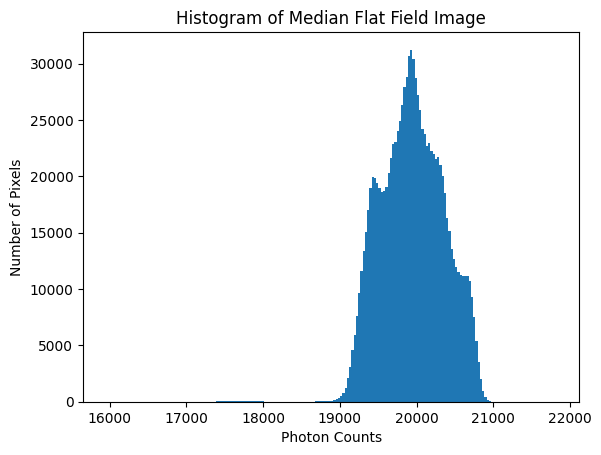

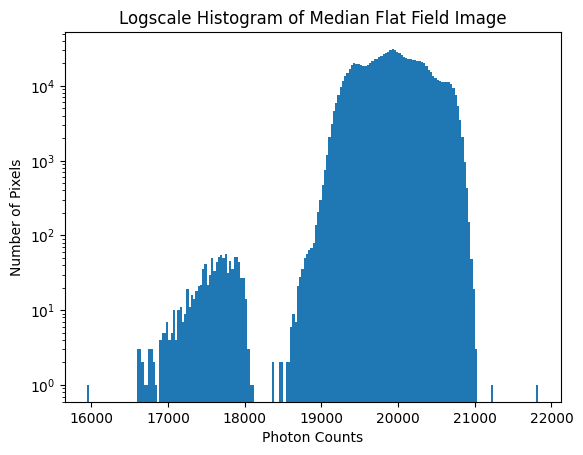

In [26]:
flat_median = median_values.flatten()
histogram = plt.hist(flat_median, range=(np.min(flat_median), np.max(flat_median)), bins=200)
plt.xlabel('Photon Counts')
plt.ylabel("Number of Pixels")
plt.title("Histogram of Median Flat Field Image")
plt.show()
histogram = plt.hist(flat_median, range=(np.min(flat_median), np.max(flat_median)), bins=200)
plt.xlabel('Photon Counts')
plt.ylabel("Number of Pixels")
plt.title("Logscale Histogram of Median Flat Field Image")
plt.yscale("log")
plt.show()

As seen by the logscale histogram of the master flat field, there are no obvious dead pixels. By the definition of dead pixels, we can assume that they would manifest as photon count values well below the majority of the data. While there is one smaller count at 16,000, this is not enough of a gap between the rest of the data to conclude it as dead.

## 4.4 Spectroscopic Calibration
This next section involves learning how to calibrate and use the DADOS spectrograph and ST402ME camera. A spectrograph is an instrument that disperses light into its constituent wavelengths, creating a spectrum. 

### 4.4.1 Calibrating Flat Fields
Much like data taken with the STL1001, we must calibrate our spectrograph images by taking flat fields of a known spectra. Similarly, these flat fields are essential in normalizing the relative biases of individual pixels. We used the well known emission spectra of Neon as our test source for these experiments. The DADOS spectrograph has 3 slits, corresponding to 25, 35, and 50 micrometers. Below is an image of our full spectrograph flat field, displaying the 3 bands: 

Text(0.5, 1.0, 'Full Spectrum Columns')

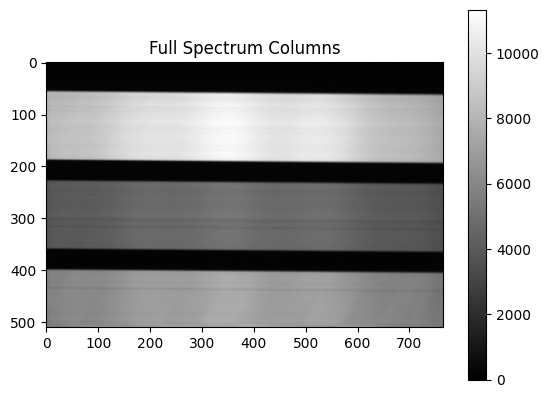

In [27]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

spectra_image = fits.open('../Lab_1/images/lab1_3_4_8.00000009.FIT')

data = spectra_image[0].data
plt.imshow(data,cmap='gray')
plt.colorbar()
plt.title('Full Spectrum Columns')

Our data only concerns the top band, which corresponds to 50 micrometers. As such, we can easily crop out the array to solely include this top slit:

(200, 765)


Text(0.5, 1.0, '50$\\mu$m Slit Crop')

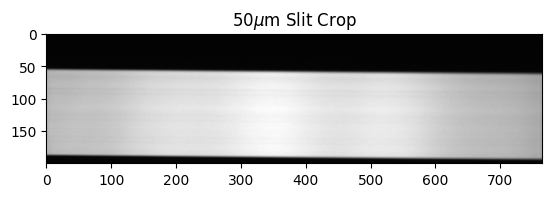

In [28]:
#Crop data to only include the top band (50um)

crop = data[:200,:]
print(crop.shape)
plt.imshow(crop,cmap='gray')
plt.title(r'50$\mu$m Slit Crop')

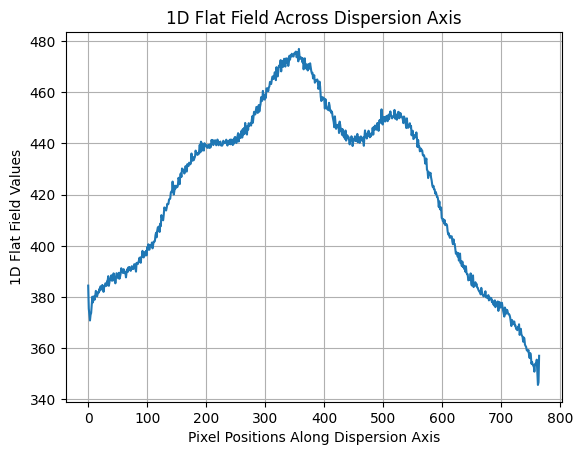

In [30]:
flat_list = []

# find and open the Flat Fields and store them all in one list
file_prefix = "lab1_3_4_8.0000000"
file_end = ".FIT"
pixel_data = [None]*9

for i in range(0, 9, 1):
    filename = file_prefix + str(i) + file_end
    list = fits.open('../Lab_1/images/'+filename)
    image_data = list[0].data
    pixel_data[i] = image_data


# open a 2d list to store median values
median_values = np.zeros((200, 765)) #the cropped image is a 200 x 765 pixel array

# run through and calculate the median value for each pixel, 200 for y-axis and 765 for x-axis
for i in range(0, 200):
    for j in range(0, 765):
        values = [pixel_data[x][i][j] for x in range(0,9)]
        median_values[i][j] = np.median(values)

# Calculate the 1D flat field values by averaging along the y-axis
flat_field_1d = np.mean(median_values, axis=0)

# Plotting the 1D flat field values against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, flat_field_1d)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('1D Flat Field Values')
plt.title('1D Flat Field Across Dispersion Axis')
plt.grid(True)
plt.show()

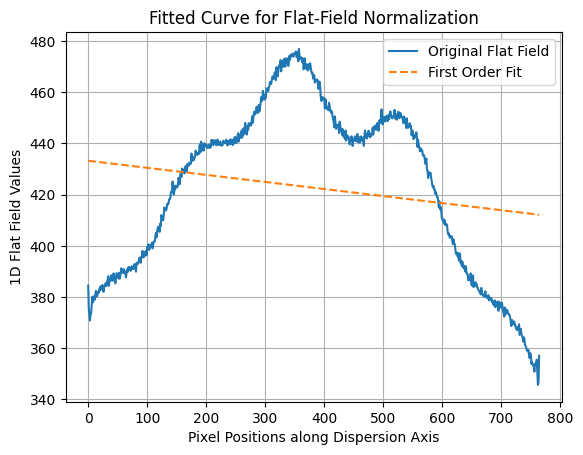

In [31]:
from astropy.modeling import models, fitting

# Pixel positions along the dispersion axis
dispersion_axis = np.arange(765)  #765 is the length of the dispersion axis

# Initialize various polynomial models for fitting
first_order = models.Polynomial1D(degree=1)


# Initialize a fitting algorithm
fitter = fitting.LinearLSQFitter()

# Fit the models to the 1D flat-field spectrum
first_fit = fitter(first_order, dispersion_axis, flat_field_1d)

# Generate the fit using the fitted model
first_fit_curve = first_fit(dispersion_axis)

# Plot the original flat-field and the fitted curves
plt.plot(dispersion_axis, flat_field_1d, label='Original Flat Field')
plt.plot(dispersion_axis, first_fit(dispersion_axis), label='First Order Fit', linestyle='--')
plt.xlabel('Pixel Positions along Dispersion Axis')
plt.ylabel('1D Flat Field Values')
plt.title('Fitted Curve for Flat-Field Normalization')
plt.legend()
plt.grid(True)
plt.show()

# Divide the 2D flat-field by the fit to obtain the normalized flat-field
first_normalized_flat_field = median_values / first_fit_curve


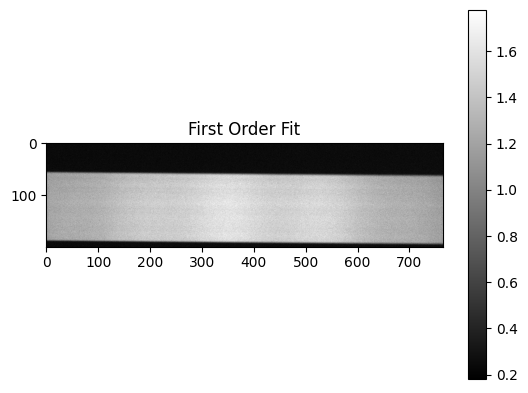

In [32]:
plt.imshow(first_normalized_flat_field,cmap='gray')
plt.title('First Order Fit')
plt.colorbar()

Text(0.5, 1.0, 'Arc Lamp Spectra')

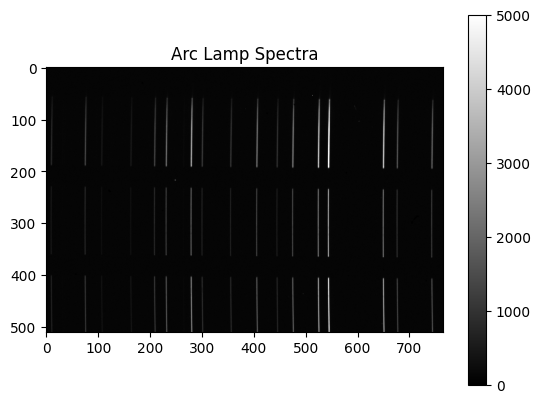

In [33]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

spectra = fits.open('../Lab_1/images/lab1_3_4_7_actual.00000002.FIT')

spectra_data = spectra[0].data
plt.imshow(spectra_data,cmap='gray',vmax=5000)
plt.colorbar()
plt.title('Arc Lamp Spectra')

(200, 765)


Text(0.5, 1.0, 'Crop of 50$\\mu$m Slit')

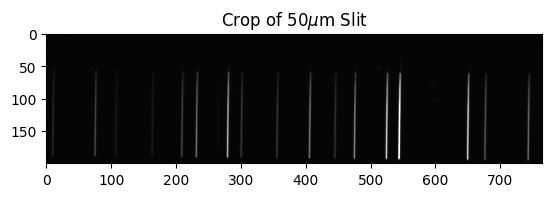

In [34]:
spectra_crop = spectra_data[:200,:]
print(spectra_crop.shape)
plt.imshow(spectra_crop,cmap='gray',vmax=5000)
plt.title(r'Crop of 50$\mu$m Slit')


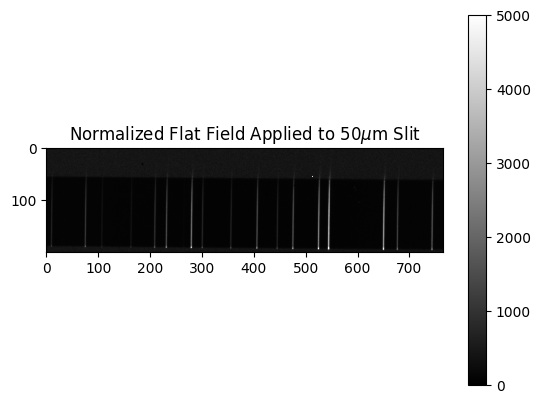

In [35]:
#Apply normalized flat field to arc lamp spectrum using the first order fit
normal = spectra_crop / first_normalized_flat_field

plt.imshow(normal,cmap='gray',vmax=5000)
plt.title(r'Normalized Flat Field Applied to 50$\mu$m Slit')
plt.colorbar()

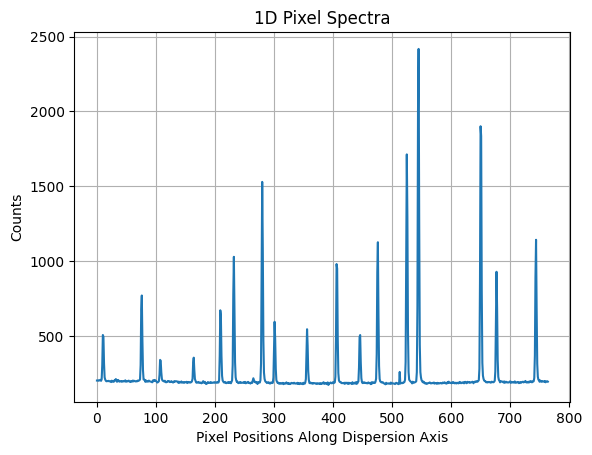

In [36]:
# Calculate the 1D spectra by averaging along the y-axis
flat_field = np.mean(normal, axis=0)

# Plot the 1D pixel counts against pixel positions along the dispersion axis
dispersion_axis = np.arange(765) 

plt.plot(dispersion_axis, flat_field)
plt.xlabel('Pixel Positions Along Dispersion Axis')
plt.ylabel('Counts')
plt.title('1D Pixel Spectra')
plt.grid(True)
plt.show()

17
17
Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
            c0                 c1        
    ----------------- -------------------
    586.9612278350182 0.09789476576477951


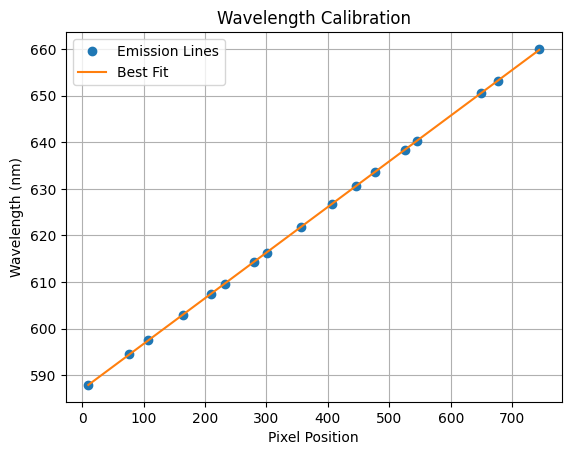

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.modeling import models, fitting

# Find peaks corresponding to known_wavelengths
peaks, _ = find_peaks(flat_field, height=300)

# Define the pixel positions of identified peaks
pixel_positions = peaks
print(len(pixel_positions))

# Known Neon spectrum emission lines provied by https://www.atomtrace.com/elements-database/element/10
known_wavelengths = [588, 594.5, 597.6,603, 607.5, 609.54, 614.22, 616.3,621.76,626.7, 630.6,633.5,638.4,640.22,650.62,653.22,660]
print(len(known_wavelengths))
    
# Define the model for fitting
linear_model = models.Polynomial1D(degree=1)

# Perform the fitting
fitter = fitting.LinearLSQFitter()
best_fit = fitter(linear_model, pixel_positions, known_wavelengths)

# Plot the data and the best-fit line
plt.plot(pixel_positions, known_wavelengths, 'o', label='Emission Lines')
plt.plot(pixel_positions, best_fit(pixel_positions), label='Best Fit')
plt.xlabel('Pixel Position')
plt.ylabel('Wavelength (nm)')
plt.title('Wavelength Calibration')
plt.grid(True)
plt.legend()

# Display the fit parameters
print(best_fit)
plt.show()


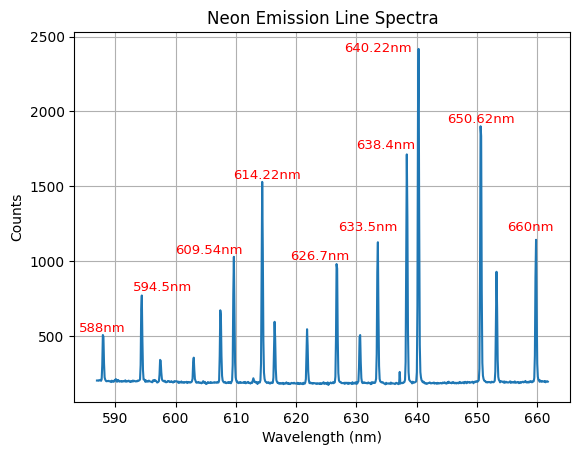

In [38]:
# Using best fit equation, adjust x-axis from pixels to nm
pixels = np.arange(765) 
wavelength_axis = 586.9612278350182 + 0.09789476576477951*pixels

plt.plot(wavelength_axis, flat_field)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.title('Neon Emission Line Spectra')

#Add labels for stronger emission lines
plt.text(584,530,'588nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(593,800,'594.5nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(600,1050,'609.54nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(609.54,1550,'614.22nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(619,1010,'626.7nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(627,1200,'633.5nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(630,1750,'638.4nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(628,2400,'640.22nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(645,1925,'650.62nm',color='red',alpha=1.0,fontsize=9.5)
plt.text(655,1200,'660nm',color='red',alpha=1.0,fontsize=9.5)

plt.grid(True)
plt.show()

In [39]:
#Find span of spectrograph by taking the range

print(wavelength_axis[0])
print(wavelength_axis[764])
span = wavelength_axis[764] - wavelength_axis[0]

print(f'The length of the spectropgraph is {span}nm ({span*10} Angstroms)')

586.9612278350182
661.7528288793098
The length of the spectropgraph is 74.79160104429161nm (747.9160104429161 Angstroms)


In [40]:
#Divide the range by 765 (number of pixels) to find the dispersion (nm/px)

dispersion = span/765

print(rf'The dispersion is {dispersion*10} A/px')


The dispersion is 0.9776679875070798 A/px
